# Shroomify Image Classification

### first we getting the exciting dataset from kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ilhamnaufal","key":"4f87f3b865e073a6e6e939132aec991e"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d marcosvolpato/edible-and-poisonous-fungi

 97% 249M/257M [00:07<00:00, 31.7MB/s]
100% 257M/257M [00:07<00:00, 35.8MB/s]


### Unzip the dataset

In [ ]:
import zipfile
#local_zip = '/content/mushrooms-classification-common-genuss-images.zip'
local_zip = '/content/edible-and-poisonous-fungi.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/edible-and-poisonous-fungi/data')
zip_ref.close()

##Import Packages##

In [ ]:
import os
import seaborn as sns
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub 
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import shutil
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

## Common Functions

In [ ]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    balance=list(df[column].value_counts())
    print (balance)
    return df

# Preprocess image

In [ ]:
def preprocess_image(item):
    image_string = tf.io.read_file(item[0])
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image_resized = tf.image.resize(image_decoded, (IMAGE_SIZE, IMAGE_SIZE))
    image_resized = tf.cast(image_resized, tf.float32) / 255.0
    return image_resized, tf.strings.to_number(item[1], tf.int64)

In [ ]:
from sklearn.model_selection import train_test_split
def preprocess (sdir, trsplit, vsplit):
    filepaths=[]
    labels=[]    
    classlist=os.listdir(sdir)
    for klass in classlist:
        classpath=os.path.join(sdir,klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)       
    # split df into train_df and test_df 
    dsplit=vsplit/(1-trsplit)
    strat=df['labels']    
    train_df, dummy_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=123, stratify=strat)
    strat=dummy_df['labels']
    valid_df, test_df=train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)
    print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
    print(train_df['labels'].value_counts())
    print(test_df['labels'].value_counts())
    print(valid_df['labels'].value_counts())
    return train_df, test_df, valid_df

# Get TFDS

In [ ]:
def get_dataset(edible_fungies, poisonous_fungies, mode, batch_size):
    x = list(edible_fungies) + list(poisonous_fungies)
    y = [0] * len(edible_fungies) + [1] * len(poisonous_fungies)
    items = [(a, b) for (a, b) in zip(x, y)]
    dataset = tf.data.Dataset.from_tensor_slices(np.array(items)).shuffle(len(x))
    dataset = dataset.map(preprocess_image).batch(batch_size)
    return dataset

## Get Balanced Dataset

In [ ]:
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()
    train_df=trim (train_df, max_samples, min_samples, column)    
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path)
    # create and store the augmented images  
    total=0
    gen=tf.keras.preprocessing.image.ImageDataGenerator(
        horizontal_flip=True,  
        rotation_range=20, 
        width_shift_range=.2,
        height_shift_range=.2, 
        zoom_range=.2)
    groups=train_df.groupby('labels') # group by class
    for label in train_df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< max_samples: # if the class has less than target number of images
            aug_img_count=0
            delta=max_samples-sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images    
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=image_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    if total>0:
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)     
            flist=os.listdir(classpath)    
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)
        ndf=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
    else:
        ndf=train_df
    print (list(ndf['labels'].value_counts()) )
    return ndf

## Import Dataset

In [ ]:
base_path = "/content/edible-and-poisonous-fungi/data/"
train_df, test_df, valid_df= preprocess(base_path, .8,.1)

train_df length:  2720   test_df length:  341   valid_df length:  340
poisonous sporocarp             1087
poisonous mushroom sporocarp     688
edible mushroom sporocarp        572
edible sporocarp                 373
Name: labels, dtype: int64
poisonous sporocarp             137
poisonous mushroom sporocarp     86
edible mushroom sporocarp        72
edible sporocarp                 46
Name: labels, dtype: int64
poisonous sporocarp             136
poisonous mushroom sporocarp     86
edible mushroom sporocarp        71
edible sporocarp                 47
Name: labels, dtype: int64


In [ ]:
max_samples= 688
min_samples=0
column='labels'
working_dir = r'./'
img_size=(300, 500)
ndf=balance(train_df,max_samples, min_samples, column, working_dir, img_size)

[688, 688, 572, 373]
Found 373 validated image filenames.
Found 572 validated image filenames.
Total Augmented images created=  431
[688, 688, 688, 688]


# EDA

In [ ]:
label = ndf.groupby('labels')
edible_sporocarp = label.get_group('edible sporocarp')
edible_mushroom_sporocarp = label.get_group('edible mushroom sporocarp')
poisonous_sporocarp = label.get_group('poisonous sporocarp')
poisonous_mushroom_sporocarp =label.get_group('poisonous mushroom sporocarp')

train_edible_sporocarp = list(set(edible_sporocarp['filepaths']))
train_edible_mushroom_sporocarp = list(set(edible_mushroom_sporocarp['filepaths']))
train_poisonous_sporocarp = list(set(poisonous_sporocarp['filepaths']))
train_poisonous_mushroom_sporocarp = list(set(poisonous_mushroom_sporocarp['filepaths']))


train_edible_fungies = list(set(train_edible_sporocarp + train_edible_mushroom_sporocarp))
train_poisonous_fungies = list(set(train_poisonous_sporocarp + train_poisonous_mushroom_sporocarp))


In [ ]:
label = valid_df.groupby('labels')
edible_sporocarp = label.get_group('edible sporocarp')
edible_mushroom_sporocarp = label.get_group('edible mushroom sporocarp')
poisonous_sporocarp = label.get_group('poisonous sporocarp')
poisonous_mushroom_sporocarp =label.get_group('poisonous mushroom sporocarp')

valid_edible_sporocarp = list(set(edible_sporocarp['filepaths']))
valid_edible_mushroom_sporocarp = list(set(edible_mushroom_sporocarp['filepaths']))
valid_poisonous_sporocarp = list(set(poisonous_sporocarp['filepaths']))
valid_poisonous_mushroom_sporocarp = list(set(poisonous_mushroom_sporocarp['filepaths']))


valid_edible_fungies = list(set(valid_edible_sporocarp + valid_edible_mushroom_sporocarp))
valid_poisonous_fungies = list(set(valid_poisonous_sporocarp + valid_poisonous_mushroom_sporocarp))


### Number of Edible Fungies:

In [ ]:
len(train_edible_fungies)

### Number of poisonous Fungies:

In [ ]:
len(train_poisonous_fungies)

In [ ]:
batch_size = 32
num_batch_per_epoch = min(len(train_edible_fungies), len(train_poisonous_fungies)) // batch_size
print("Number batch per epoch: ",num_batch_per_epoch)

Number batch per epoch:  43


### File path of edible and poisonous fungies images:

In [ ]:
train_poisonous_fungies[:10]

['/content/edible-and-poisonous-fungi/data/edible mushroom sporocarp/ce (331).jpg',
 './aug/edible sporocarp/aug-_10_6132247.jpg',
 '/content/edible-and-poisonous-fungi/data/edible sporocarp/ncvc (323).jpg',
 '/content/edible-and-poisonous-fungi/data/edible mushroom sporocarp/ce (307).jpg',
 '/content/edible-and-poisonous-fungi/data/edible mushroom sporocarp/ce (659).jpg',
 '/content/edible-and-poisonous-fungi/data/edible sporocarp/ncvc (125).jpg',
 './aug/edible sporocarp/aug-_195_4232904.jpg',
 '/content/edible-and-poisonous-fungi/data/edible mushroom sporocarp/ce (641).jpg',
 './aug/edible sporocarp/aug-_264_1615655.jpg',
 '/content/edible-and-poisonous-fungi/data/edible mushroom sporocarp/ce (436).jpg']

In [ ]:
train_poisonous_fungies[:10]

['/content/edible-and-poisonous-fungi/data/poisonous mushroom sporocarp/cv (565).jpg',
 '/content/edible-and-poisonous-fungi/data/poisonous sporocarp/nncv (455).jpg',
 '/content/edible-and-poisonous-fungi/data/poisonous mushroom sporocarp/cv (140).jpg',
 '/content/edible-and-poisonous-fungi/data/poisonous mushroom sporocarp/cv (268).jpg',
 '/content/edible-and-poisonous-fungi/data/poisonous mushroom sporocarp/cv (267).jpg',
 '/content/edible-and-poisonous-fungi/data/poisonous sporocarp/nncv (1135).jpg',
 '/content/edible-and-poisonous-fungi/data/poisonous sporocarp/nncv (699).jpg',
 '/content/edible-and-poisonous-fungi/data/poisonous sporocarp/nncv (865).jpg',
 '/content/edible-and-poisonous-fungi/data/poisonous mushroom sporocarp/cv (449).jpg',
 '/content/edible-and-poisonous-fungi/data/poisonous mushroom sporocarp/cv (11).jpg']

### Display file of edible fungies images:

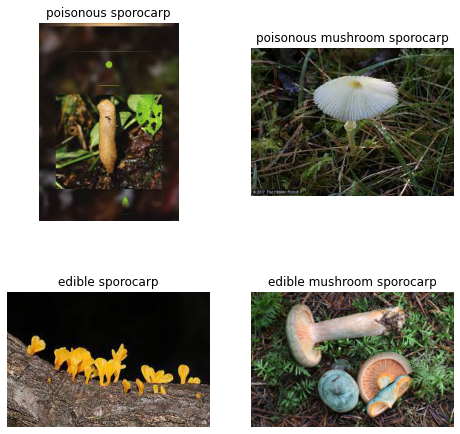

In [ ]:
import matplotlib.image as mpimg
# Displaying examples from each class
nrows = 2
ncols = 2

pos = 0

for subfolder in os.listdir(base_path):
    
    image_file = os.listdir(os.path.join(base_path, subfolder))[0]
    
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    pos += 1
    sp = plt.subplot(nrows, ncols, pos)

    cur_image = mpimg.imread(os.path.join(base_path, subfolder, image_file))
    plt.imshow(cur_image)
    plt.title(subfolder)
    plt.axis('Off')

### Display file of poisonous fungies images:

# Model Development

## Model Building with Transfer Learning

In [ ]:
IMAGE_SIZE = 224
handle_base = "mobilenet_v2"
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
feature_extractor.trainable = False 

In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 6

## Model Training

In [ ]:
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

EPOCHS = 50
train_dataset = get_dataset(train_edible_fungies, train_poisonous_fungies, "train", batch_size)
valid_dataset = get_dataset(valid_edible_fungies, valid_poisonous_fungies, "valid", batch_size)
history = model.fit(train_dataset,
                    
                    epochs=EPOCHS,
                    validation_data=valid_dataset)

Epoch 1/50
86/86 [==============================] - 24s 109ms/step - loss: 0.6473 - accuracy: 0.6199 - val_loss: 0.5606 - val_accuracy: 0.7118
Epoch 2/50
86/86 [==============================] - 10s 113ms/step - loss: 0.5142 - accuracy: 0.7347 - val_loss: 0.4959 - val_accuracy: 0.7588
Epoch 3/50
86/86 [==============================] - 9s 109ms/step - loss: 0.4723 - accuracy: 0.7733 - val_loss: 0.5292 - val_accuracy: 0.7265
Epoch 4/50
86/86 [==============================] - 11s 132ms/step - loss: 0.4354 - accuracy: 0.7907 - val_loss: 0.4744 - val_accuracy: 0.7735
Epoch 5/50
86/86 [==============================] - 10s 114ms/step - loss: 0.4096 - accuracy: 0.7925 - val_loss: 0.4348 - val_accuracy: 0.7971
Epoch 6/50
86/86 [==============================] - 10s 112ms/step - loss: 0.3807 - accuracy: 0.8183 - val_loss: 0.4548 - val_accuracy: 0.7735
Epoch 7/50
86/86 [==============================] - 9s 101ms/step - loss: 0.3621 - accuracy: 0.8354 - val_loss: 0.3904 - val_accuracy: 0.8118
E

# Model Evaluation

## Loss & Accuracy over time

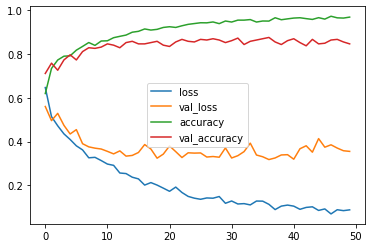

In [ ]:
# Loss during training:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss','accuracy', 'val_accuracy']].plot();

### Prediction with validation dataset

In [ ]:
predicted_labels = []
actual_labels = []
for (x_batch, y_true) in valid_dataset:
    y_pred = model(x_batch)
    predicted_labels += list(np.array(tf.argmax(y_pred, axis=-1)))
    actual_labels += list(np.array(y_true))

### Confusion Matrix

[[ 93  25]
 [ 27 195]]


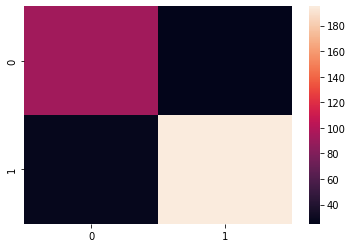

In [ ]:
matrix = confusion_matrix(actual_labels, predicted_labels)
print(matrix)
sns.heatmap(matrix)

### Classification Report

In [ ]:
cls_report = classification_report(predicted_labels, actual_labels)
print(cls_report)

              precision    recall  f1-score   support

           0       0.79      0.78      0.78       120
           1       0.88      0.89      0.88       220

    accuracy                           0.85       340
   macro avg       0.83      0.83      0.83       340
weighted avg       0.85      0.85      0.85       340



### Save the model

In [ ]:
model.save("shroomify_model.h5")

In [ ]:
MUSHROOM_SAVED_MODEL = "mushroom_saved_model"
# Use TensorFlow's SavedModel API to export the SavedModel from the trained Keras model
tf.saved_model.save(model, MUSHROOM_SAVED_MODEL)

INFO:tensorflow:Assets written to: mushroom_saved_model/assets


INFO:tensorflow:Assets written to: mushroom_saved_model/assets


In [ ]:
%%bash -s $MUSHROOM_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_2'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [ ]:
loaded = tf.saved_model.load(MUSHROOM_SAVED_MODEL)

In [ ]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense_2': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense_2')}


## Convert with TFLite's Converter

In [ ]:
# Intialize the TFLite converter to load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(MUSHROOM_SAVED_MODEL)

# Set the optimization strategy for 'size' in the converter 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

# Use the tool to finally convert the model
tflite_model = converter.convert()

In [ ]:
tflite_model_file = 'mushroom_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

## Test the TFLite Model Using the Python Interpreter

In [ ]:
# Load TFLite model and allocate tensors.
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()
    
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
valid_datasets = get_dataset(valid_edible_fungies, valid_poisonous_fungies, "valid", 1)

In [ ]:
valid_batches = valid_datasets

In [ ]:
# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(valid_batches.take(10)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


In [ ]:
#@title Utility functions for plotting
# Utilities for plotting

class_names = ['edible', 'poisonous']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    print(type(predicted_label), type(true_label))
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

<class 'numpy.int64'> <class 'numpy.int64'>


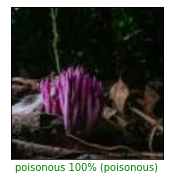

In [ ]:
#@title Visualize the outputs { run: "auto" }
index = 1 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

In [ ]:
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [ ]:
try:
    from google.colab import files
    files.download('mushroom_model.tflite')
    files.download('labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>